In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
interval = '4h'
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False)
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [3]:
ma_candidates = [10, 20, 30, 50, 60, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 200]

In [4]:
# Function to backtest strategy and calculate cumulative profit
def backtest_and_calculate_profit(df, ma):
    df['Position'] = np.where(df['close'] > df[f'MA_{ma}'], 1, 0)  # 1 for buy, 0 for sell
    df['Signal'] = df['Position'].diff()  # Buy signal when diff > 0, sell signal when diff < 0

    # Initial values
    initial_cash = 4261.48  # Starting with $10,000
    btc_holding = 0
    cash = initial_cash
    purchase_price = 0
    # stop_loss = 0 # No stop loss    
    
    stop_loss = 0.995 # 0.5% loss
    # stop_loss = 0.99 # 1% loss
    # stop_loss = 0.98 # 2% loss
    # stop_loss = 0.97 # 3% loss

    for i in range(0, len(df)):
        price = df['close'].iloc[i]

        # Stop loss check: Sell if the price drops more than 1% below the purchase price
        if btc_holding > 0 and price < purchase_price * stop_loss:
            sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower 
            cash = btc_holding * sell_price  # Sell all BTC and hold cash
            btc_holding = 0  # No BTC left after selling
            current_time = df['timestamp'].iloc[i]
            print(f"{current_time}: Stop loss triggered! Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT")

        else:
            # Buy signal
            if df['Signal'].iloc[i] == 1:  # Crosses above MA
                # if price < df['MA_200'].iloc[i]: # 장기 이평 아래면 안 산다. -> 하락추세로 판단
                #     continue
                if cash > 0:
                    purchase_price = price #* (1 + 0.01 / 100) # buy price 0.01% higher
                    btc_holding = cash / purchase_price  # Buy BTC with all available cash
                    cash = 0  # No cash left after buying
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Bought BTC at {purchase_price:,.2f}, holding {btc_holding:.4f} BTC")

            # Sell signal
            elif df['Signal'].iloc[i] == -1:  # Crosses below MA
                if btc_holding > 0:
                    sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower
                    cash = btc_holding * sell_price  # Sell all BTC and hold cash
                    btc_holding = 0  # No BTC left after selling
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT\n")
        
        # Calculate current portfolio value (cash + value of BTC)
        portfolio_value = cash + (btc_holding * price)
        # Update the portfolio value for each iteration
        df.loc[i, 'portfolio_value'] = portfolio_value

    # Drop 'Signal' and 'Position' columns
    df = df.drop(columns=['Signal', 'Position'])

    # df['portfolio_value'] = portfolio_value
    # print(f"Final value for MA {ma}: {portfolio_value:,.2f} USDT")
    return df

## Filter 2018, 2022

In [5]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

btc_data_2022 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2022])]
btc_data_2022 = btc_data_2022.drop(btc_data_2022[~pd.to_datetime(btc_data_2022['timestamp']).dt.year.isin([2022])].index)
btc_data_2022 = btc_data_2022.reset_index(drop=True)

In [6]:
btc_data_2018.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_100,MA_110,MA_120,MA_130,MA_140,MA_150,MA_160,MA_170,MA_180,MA_200
0,2018-01-01 00:00:00,13715.65,13715.65,13155.38,13410.03,1676.204807,13066.269,13603.527,13953.571333,13952.4830,...,15397.2857,15492.027000,15548.534167,15588.212000,15503.480643,15487.237467,15300.505563,15072.736176,14855.033556,14377.72440
1,2018-01-01 04:00:00,13434.98,13818.55,13322.15,13570.35,1302.214836,13191.905,13572.939,13870.749667,13957.8900,...,15357.5611,15469.636636,15521.620667,15574.137769,15486.983143,15482.354200,15311.570250,15086.882882,14869.696389,14396.09215
2,2018-01-01 08:00:00,13569.98,13735.24,13001.13,13220.56,1319.755931,13209.961,13497.717,13792.430667,13956.8802,...,15313.3969,15447.686364,15493.458667,15556.867615,15470.683143,15478.491400,15321.111250,15097.768765,14882.360722,14410.94980
3,2018-01-01 12:00:00,13220.56,13330.00,12750.00,13247.00,1831.933153,13290.660,13437.567,13728.830333,13956.7778,...,15270.4686,15424.702455,15467.919667,15544.152385,15455.733071,15464.738000,15330.780062,15107.781941,14896.456667,14425.03490
4,2018-01-01 16:00:00,13247.00,13290.65,12940.00,13240.37,1092.337234,13318.491,13385.585,13677.067667,13974.6674,...,15230.3723,15398.714909,15440.639417,15521.693615,15445.307071,15452.960400,15337.170125,15120.249882,14909.558056,14437.35525


In [7]:
btc_data.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_100,MA_110,MA_120,MA_130,MA_140,MA_150,MA_160,MA_170,MA_180,MA_200
0,2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Test all ma candidates

In [8]:
portfolio_value_by_ma = {}
for ma in ma_candidates:
    profit = backtest_and_calculate_profit(btc_data, ma)
    portfolio_value_by_ma[ma] = profit['portfolio_value'].iloc[-1]

2017-08-19 20:00:00: Bought BTC at 4,139.98, holding 1.0293 BTC
2017-08-20 00:00:00: Stop loss triggered! Sold BTC at 4,094.62, now holding 4,214.79 USDT
2017-08-22 16:00:00: Bought BTC at 3,984.24, holding 1.0579 BTC
2017-08-25 20:00:00: Sold BTC at 4,280.68, now holding 4,528.38 USDT

2017-08-26 04:00:00: Bought BTC at 4,319.70, holding 1.0483 BTC
2017-08-26 08:00:00: Stop loss triggered! Sold BTC at 4,288.72, now holding 4,495.91 USDT
2017-08-26 20:00:00: Bought BTC at 4,337.44, holding 1.0365 BTC
2017-08-27 00:00:00: Stop loss triggered! Sold BTC at 4,314.91, now holding 4,472.55 USDT
2017-08-28 16:00:00: Bought BTC at 4,321.65, holding 1.0349 BTC
2017-09-02 04:00:00: Sold BTC at 4,697.71, now holding 4,861.74 USDT

2017-09-05 08:00:00: Bought BTC at 4,246.82, holding 1.1448 BTC
2017-09-05 12:00:00: Stop loss triggered! Sold BTC at 4,151.00, now holding 4,752.05 USDT
2017-09-05 16:00:00: Bought BTC at 4,442.48, holding 1.0697 BTC
2017-09-05 20:00:00: Stop loss triggered! Sold BTC a

In [9]:
print (f"interval: {interval}")

for ma, value in portfolio_value_by_ma.items():
    print(f"Final value for MA {ma}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma = max(portfolio_value_by_ma, key=portfolio_value_by_ma.get)
best_value = portfolio_value_by_ma[best_ma]

print(f"The best performing for {interval} is {best_ma} MA with a final portfolio value of {best_value:,.2f} USDT")


interval: 4h
Final value for MA 10: 46,417.10 USDT
Final value for MA 20: 92,461.46 USDT
Final value for MA 30: 62,731.09 USDT
Final value for MA 50: 27,336.89 USDT
Final value for MA 60: 56,325.37 USDT
Final value for MA 90: 38,846.13 USDT
Final value for MA 100: 69,584.86 USDT
Final value for MA 110: 70,620.22 USDT
Final value for MA 120: 124,617.99 USDT
Final value for MA 130: 413,657.02 USDT
Final value for MA 140: 234,828.40 USDT
Final value for MA 150: 107,338.81 USDT
Final value for MA 160: 41,921.33 USDT
Final value for MA 170: 143,221.04 USDT
Final value for MA 180: 86,617.26 USDT
Final value for MA 200: 39,164.91 USDT
The best performing for 4h is 130 MA with a final portfolio value of 413,657.02 USDT


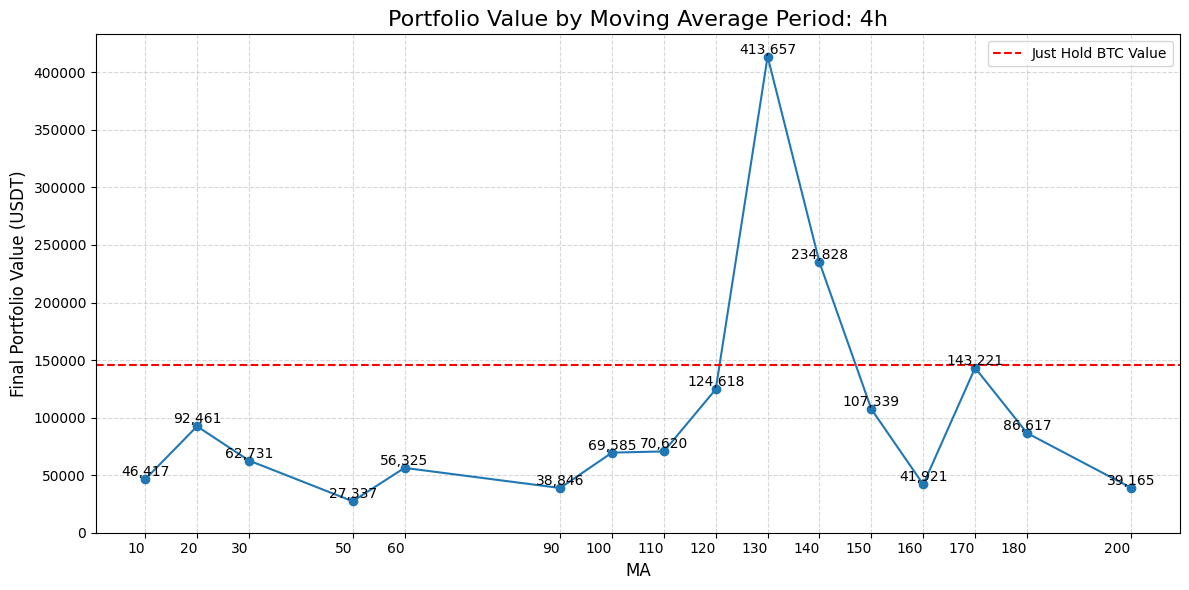

In [10]:
# Sort the dictionary by MA values
sorted_portfolio_value = dict(sorted(portfolio_value_by_ma.items()))

# Extract MA values and corresponding portfolio values
ma_values = list(sorted_portfolio_value.keys())
portfolio_values = list(sorted_portfolio_value.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(ma_values, portfolio_values, marker='o')

# Customize the plot
plt.title(f'Portfolio Value by Moving Average Period: {interval}', fontsize=16)
plt.xlabel('MA', fontsize=12)
plt.ylabel('Final Portfolio Value (USDT)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add value labels on top of each point
for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Add x-axis labels for each MA value
plt.xticks(ma_values, [f'{ma}' for ma in ma_values], rotation=0, ha='right')

# Adjust the bottom margin to accommodate the labels
plt.subplots_adjust(bottom=0.2)

# Add a horizontal line at 145,580.15
plt.axhline(y=145580.15, color='red', linestyle='--', label='Just Hold BTC Value')
plt.legend()

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()


## Test {ma} MA

In [11]:
ma = 130
profit_df = backtest_and_calculate_profit(btc_data, ma)
portfolio_value = profit_df['portfolio_value'].iloc[-1]
print(f"Final value interval {interval} for {ma} MA: {portfolio_value:,.2f} USDT")

2017-09-07 16:00:00: Bought BTC at 4,754.21, holding 0.8964 BTC
2017-09-07 20:00:00: Stop loss triggered! Sold BTC at 4,691.61, now holding 4,205.37 USDT
2017-09-12 04:00:00: Bought BTC at 4,361.00, holding 0.9643 BTC
2017-09-12 08:00:00: Sold BTC at 4,340.10, now holding 4,185.21 USDT

2017-09-27 04:00:00: Bought BTC at 3,968.00, holding 1.0547 BTC
2017-11-11 08:00:00: Sold BTC at 6,410.02, now holding 6,760.91 USDT

2017-11-13 12:00:00: Bought BTC at 6,589.99, holding 1.0259 BTC
2017-11-13 16:00:00: Stop loss triggered! Sold BTC at 6,366.97, now holding 6,532.11 USDT
2017-11-14 00:00:00: Bought BTC at 6,590.90, holding 0.9911 BTC
2017-11-14 04:00:00: Stop loss triggered! Sold BTC at 6,545.33, now holding 6,486.95 USDT
2017-11-14 16:00:00: Bought BTC at 6,532.06, holding 0.9931 BTC
2017-12-21 12:00:00: Sold BTC at 14,400.00, now holding 14,300.54 USDT

2017-12-21 20:00:00: Bought BTC at 15,492.64, holding 0.9231 BTC
2017-12-22 00:00:00: Stop loss triggered! Sold BTC at 13,780.00, now 

## Just holding BTC


In [12]:
# Function to calculate final value of holding BTC
def calculate_holding_value(df):
    initial_cash = 10000  # Start with $10,000 in cash

    # Buy BTC at the first available price
    initial_price = df['close'].iloc[0]
    btc_holding = initial_cash / initial_price  # Buy BTC with all available cash

    # Sell BTC at the last available price
    final_price = df['close'].iloc[-1]
    final_value = btc_holding * final_price  # Calculate the value of the BTC holding

    print(f"Initial BTC price: {initial_price:.2f} USDT")
    print(f"Final BTC price: {final_price:.2f} USDT")
    print(f"Final value of holding BTC: {final_value:,.2f} USDT")
    
    return final_value

In [13]:

# Example usage
# Assuming 'df' is a DataFrame with your historical price data (e.g., 1-hour BTC/USDT prices)
final_value = calculate_holding_value(btc_data)

Initial BTC price: 4349.99 USDT
Final BTC price: 65502.41 USDT
Final value of holding BTC: 150,580.60 USDT


## Portfolio cumulative profit

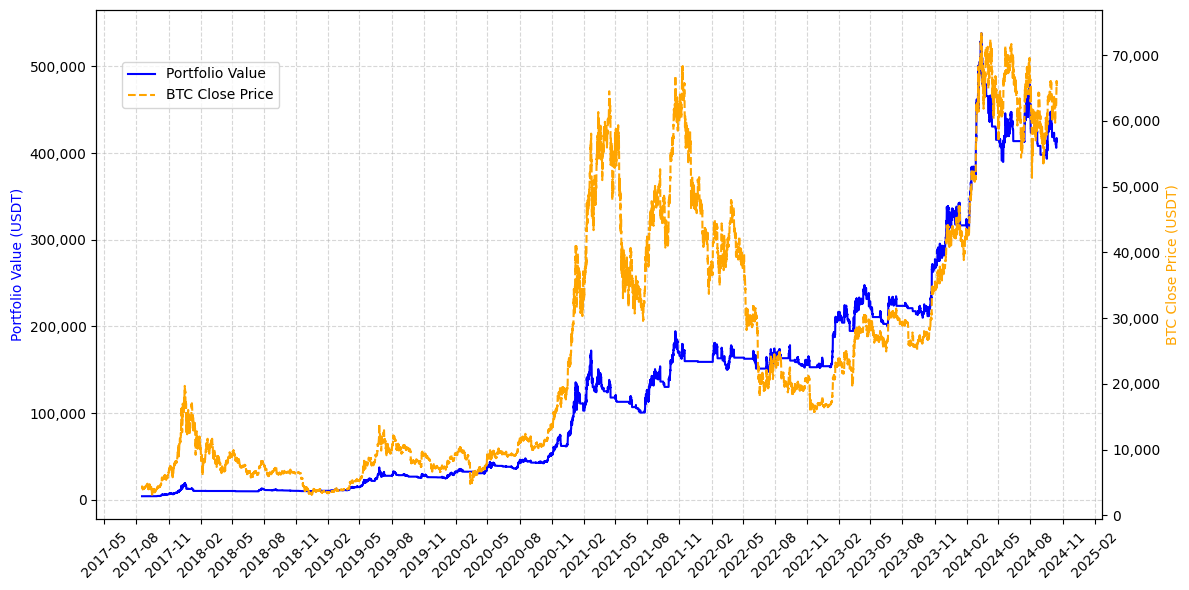

In [18]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the portfolio value over time on the left y-axis
ax1.plot(btc_data['timestamp'], btc_data['portfolio_value'], label='Portfolio Value', color='blue')

# Set x-axis ticks to show every 3 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set the y-axis label for portfolio value
ax1.set_ylabel('Portfolio Value (USDT)', color='blue')

# Format y-axis tick labels with commas on the left axis
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Enable grid for left axis
ax1.grid(True, linestyle='--', alpha=0.5)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the BTC close price on the right y-axis
ax2.plot(btc_data['timestamp'], btc_data['close'], label='BTC Close Price', color='orange', linestyle='--')

# Set the y-axis label for BTC close price
ax2.set_ylabel('BTC Close Price (USDT)', color='orange')

# Optionally, format the y-axis on the right if needed (e.g., formatting for currency)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Add a legend for both plots
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Adjust layout to prevent cutting off labels
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2017, 2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2017, 2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

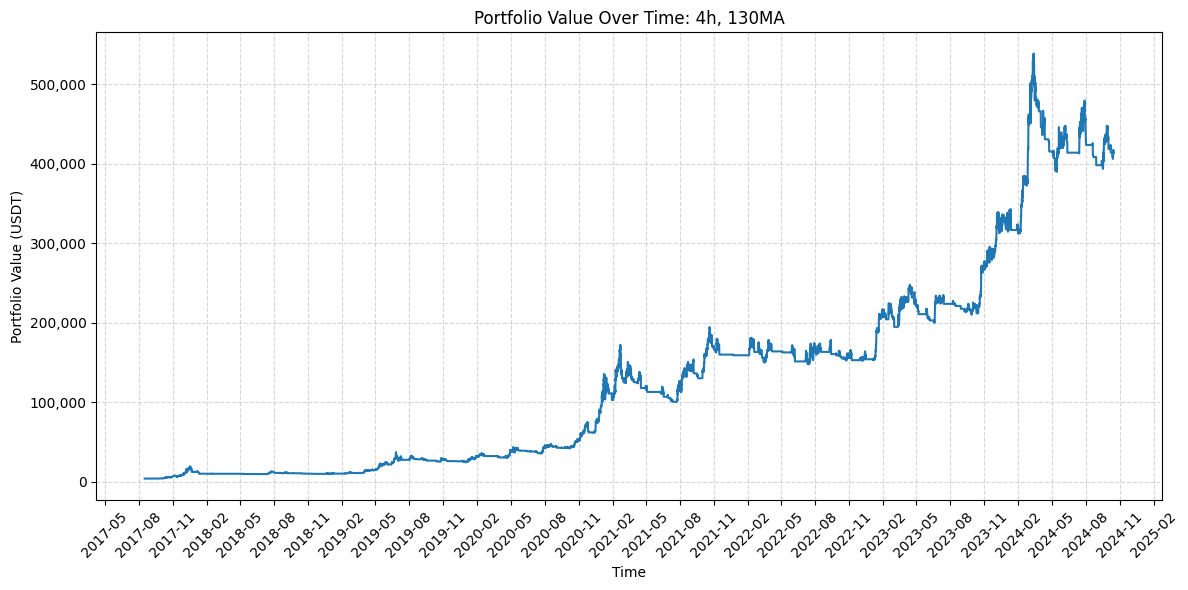

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Plot the portfolio value over time
plt.plot(btc_data['timestamp'], btc_data['portfolio_value'], label='Portfolio Value')
plt.gca().autoscale()

# Set x-axis limits to show only 2017
# start_date = datetime(2017, 1, 1)
# end_date = datetime(2017, 12, 31)
# plt.xlim(start_date, end_date)

# Set x-axis ticks to show every 3 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set y-axis limits
# plt.ylim(-100000, 1300000)

# Set y-axis ticks to every 100,000 units
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100000))  # Tick every 100k

# Format y-axis tick labels with commas
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas
# Set labels and title
plt.xlabel('Time')
plt.ylabel('Portfolio Value (USDT)')
plt.title(f'Portfolio Value Over Time: {interval}, {ma}MA')

# Enable grid with a dashed line style
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()